#### EDA notebook - Arnab

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from collections import defaultdict

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive")

%cd "/content/drive/My Drive/omdena-data/newdata"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/omdena-data/newdata


In [0]:
# read data
df = pd.read_csv("OUTPUT_WBI_exposer_cyclones_v2.csv", sep=";")

In [4]:
# features
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_POP', '34KN_ASSETS', '64KN_POP', '64KN_ASSETS',
       '96KN_POP', '96KN_ASSETS', 'CPI', 'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_

In [0]:
# drop rows with NaN
df.dropna(inplace = True)

In [0]:
# convert 'Income_level_Final' feature to integer
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, range(1, len(unique_list)+1)))
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

In [0]:
# choosing some numeric features - 
keep_cols = ['TOTAL_AFFECTED', 'TOTAL_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
             'V_LAND_KN', 'Population density (people per sq. km of land area)',
             'Rural population (% of total population)', 'Income_level_Final', 'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj']
df = df[keep_cols]
# df['pop_max_34_adj'] = df['pop_max_34_adj']*0.5 + df['pop_max_50_adj']*0.3 + df['pop_max_64_adj']*0.2
# df['pop_max_64_adj'] = df['pop_max_34_adj'] - df['pop_max_64_adj']
# df.drop(columns=['pop_max_50_adj', 'pop_max_64_adj'], inplace=True)


In [0]:
# save the list of columns for later
cols = df.columns

In [0]:
# scale the features
min_max_scaler = preprocessing.MinMaxScaler()
X = df.values
x_scaled = min_max_scaler.fit_transform(X)
df = pd.DataFrame(x_scaled)
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

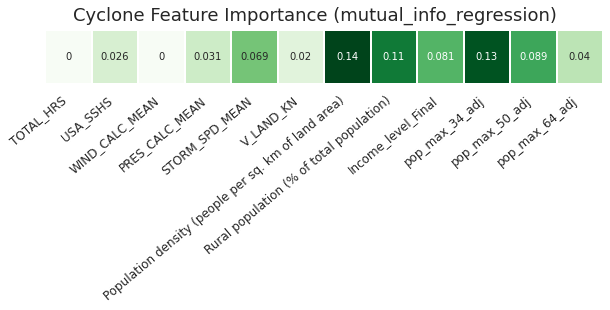

In [10]:
# feature importance using mutual_info_regression
# reference: https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn

cyclone_mutual_information = mutual_info_regression(X, y)
plt.subplots(1, figsize=(10, 1))
sns.heatmap(cyclone_mutual_information[:, np.newaxis].T, cmap='Greens', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(cols[1:], rotation=40, ha='right', fontsize=12)
plt.suptitle("Cyclone Feature Importance (mutual_info_regression)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)

In [11]:
# reference: https://www.kaggle.com/residentmario/automated-feature-selection-with-sklearn
trans = GenericUnivariateSelect(score_func=mutual_info_regression, mode='percentile', param=90)
X_trans = trans.fit_transform(X, y)
columns_retained_Select = cols[1:][trans.get_support()].values
subset_df = pd.DataFrame(X_trans, columns=columns_retained_Select)

# let's see the features retained after keeping 90% - it matches the above list after dropping the ones with zero importance
subset_df.columns

Index(['USA_SSHS', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'V_LAND_KN',
       'Population density (people per sq. km of land area)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj'],
      dtype='object')

R-squared: 0.87


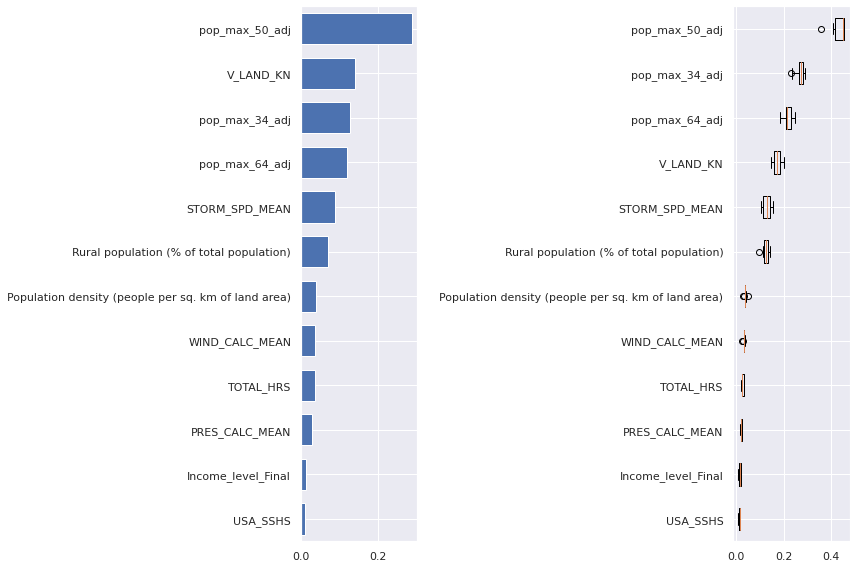

In [12]:
"""
reference:
https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py
"""
features = cols[1:]

clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X, y)
print(f"R-squared: {clf.score(X, y):.2f}")

result = permutation_importance(clf, X, y, n_repeats=10,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices,
         clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(features[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=features[perm_sorted_idx])
fig.tight_layout()
plt.show()

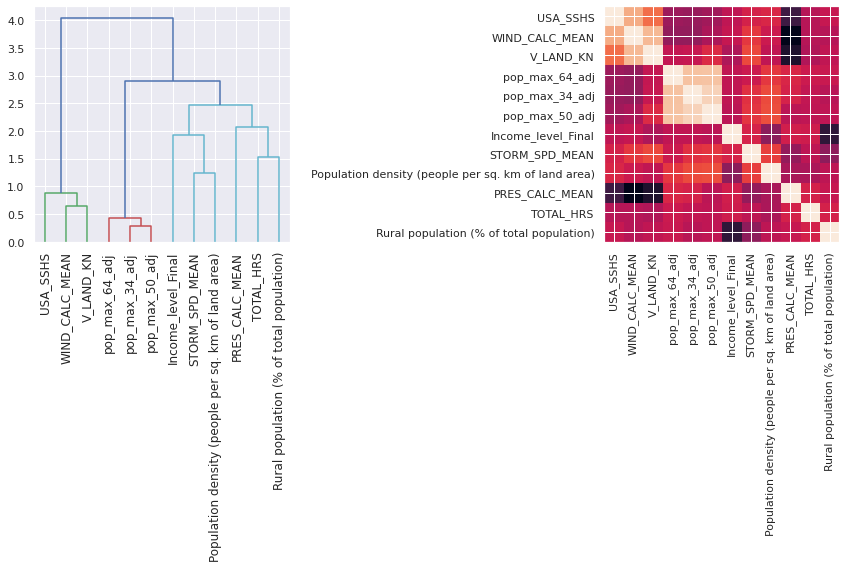

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1,
                              leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()


### TODO: Explain the dendogram chart.